In [1]:
import pandas as pd
import numpy as np
from typing import Callable
from tqdm.notebook import tqdm
import os

In [2]:
from dsl import spec, SpecTracker
from dsl.grammar import (
    create_variable as V,
    Expectation as E,
    Specification
)
from dsl.tests.database.database import Database

In [3]:
os.environ["PATH"] = os.pathsep + os.path.join("..", "mlp_solver")

In [4]:
!ipopt -v

Ipopt 3.12.13 (Linux x86_64), ASL(20211109)



In [5]:
import logging

level = logging.CRITICAL
logger = logging.getLogger()
logger.setLevel(level)
for handler in logger.handlers:
    handler.setLevel(level)

In [6]:
#from tqdm.notebook import tqdm
from tqdm import tqdm

In [7]:
data_fp = './dsl/tests/datasets/data/adult_income/adult_train.csv'
original_attributes = {
    "age": "continuous",
    "workclass": "Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.",
    "fnlwgt": "Final Weight (continuous): See https://www.census.gov/programs-surveys/sipp/methodology/weighting.html",
    "education": "Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.",
    "education_num": "School grade level (continuous)",
    "marital_status": "Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.",
    "occupation": "Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces",
    "relationship": "Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.",
    "race": "White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.",
    "sex": "Female, Male.",
    "capital_gain": "continuous",
    "capital_loss": "continuous.",
    "hours_per_week": "continuous.",
    "native_country": "United-States, Cambodia, England, etc.",
    "high_income": ">50k, <=50k"
}
data = pd.read_csv(data_fp, names=original_attributes.keys(), header=0)
replace = {
    ">50K": 1,
    "<=50K": 0,
    ">50K.": 1,
    "<=50K.": 0,
    "?": np.nan
}
data = data.replace(replace)
data["id"] = data.index + 1

# Expected Values

In [8]:
fed_query = lambda db: db[db.workclass == "Federal-gov"]

In [9]:
fed_view = fed_query(data)

In [10]:
len(fed_view)

960

In [11]:
fed_view.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income,id
22,35,Federal-gov,76845,9th,5,Married-civ-spouse,Farming-fishing,Husband,Black,Male,0,0,40,United-States,0,23
33,30,Federal-gov,59951,Some-college,10,Married-civ-spouse,Adm-clerical,Own-child,White,Male,0,0,40,United-States,0,34
45,57,Federal-gov,337895,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,40,United-States,1,46
53,50,Federal-gov,251585,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,55,United-States,1,54
89,43,Federal-gov,410867,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,1,90


In [12]:
def expected_gender_income(df, gender):
    return df[df.sex == gender].high_income.sum() / len(df[df.sex == gender])

In [13]:
expectation_income_fed_male = expected_gender_income(fed_view, "Male")
expectation_income_fed_female = expected_gender_income(fed_view, "Female")
print(f"Expectation of high income status for Male: {expectation_income_fed_male}")
print(f"Expectation of high income status for Female: {expectation_income_fed_female}")
print(f"Proportion: {expectation_income_fed_male / expectation_income_fed_female}")

Expectation of high income status for Male: 0.4883720930232558
Expectation of high income status for Female: 0.17777777777777778
Proportion: 2.7470930232558137


In [14]:
gov_query = lambda db: db[(db.workclass == "Federal-gov") | (db.workclass == "State-gov")]
gov_view = gov_query(data)

In [15]:
expectation_income_gov_male = expected_gender_income(gov_view, "Male")
expectation_income_gov_female = expected_gender_income(gov_view, "Female")
print(f"Expectation of high income status for Male: {expectation_income_gov_male}")
print(f"Expectation of high income status for Female: {expectation_income_gov_female}")
print(f"Proportion: {expectation_income_gov_male / expectation_income_gov_female}")

Expectation of high income status for Male: 0.4126547455295736
Expectation of high income status for Female: 0.15422885572139303
Proportion: 2.675600124240139


In [16]:
def get_values_for_term(spec_hist, term):
    xs, values = [], []
    for x, dict_vals in spec_hist:
        xs.append(x)
        values.append(dict_vals.get(term.id))
    return xs, values

# Database Simulation

In [17]:
threshold = 0.5
threshold_2 = 0.5
req_delta = 0.15

In [18]:
database = Database(data)

In [19]:
def get_spec():
    return (E(V("high_income"), given=V("sex") == "Male") \
            - E(V("high_income"), given=V("sex") == "Female") < threshold) & \
            (E(V("high_income"), given=V("race") == "White") \
            - E(V("high_income"), given=V("race") != "White") < threshold_2)

def get_spec2():
    return (E(V("high_income"), given=V("sex") == "Male") \
            - E(V("high_income"), given=V("sex") == "Female") < 0.55) & \
            (E(V("high_income"), given=V("race") == "White") \
            - E(V("high_income"), given=V("race") != "White") < threshold_2)

In [20]:
view_name = "federal-employees"

In [21]:
my_spec = get_spec()
view = database.create_materialized_view(
    view_name,
    query=(lambda data: data[data.workclass == "Federal-gov"]),
    specification=my_spec,
    observation_key="id",
    spec_args={"include_confidence": True, "delta": req_delta, "optimization_frequency": 5, "our_approach": True},
    progress_bar=tqdm
)

960it [00:09, 105.32it/s]


In [22]:
spec_history = database.views[view_name].observer.spec_val_history

In [23]:
my_spec

((E[high_income | sex = Male] - E[high_income | sex = Female] < 0.5) & (E[high_income | race = White] - E[high_income | race != White] < 0.5))

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
xs, values = get_values_for_term(spec_history, my_spec)
ys, deltas = zip(*[(value.val, value.delta) for value in values])

In [26]:
xs, ys, deltas = (np.array(t) for t in [xs, ys, deltas])

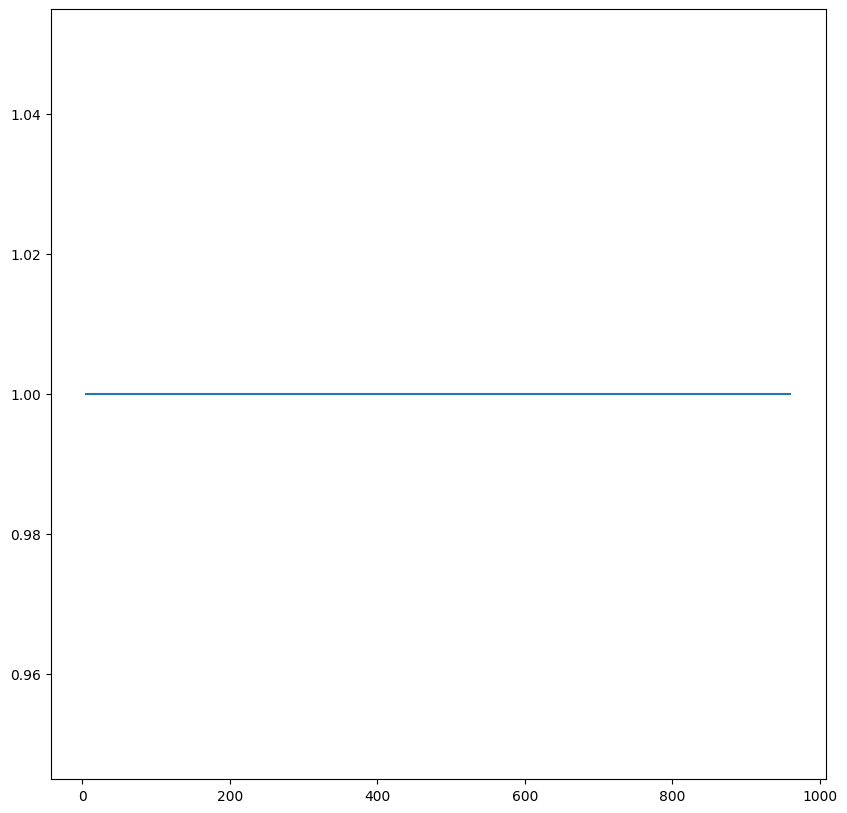

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, deltas)

In [28]:
xs, values = get_values_for_term(spec_history, my_spec.left_child.left_child.expectation_term)
ys, cs, deltas = zip(*[(value.val, value.epsilon, value.delta) for value in values])

In [29]:
xs, ys, cs, deltas = (np.array(t) for t in [xs, ys, cs, deltas])

Text(0.5, 0, '# Observad')

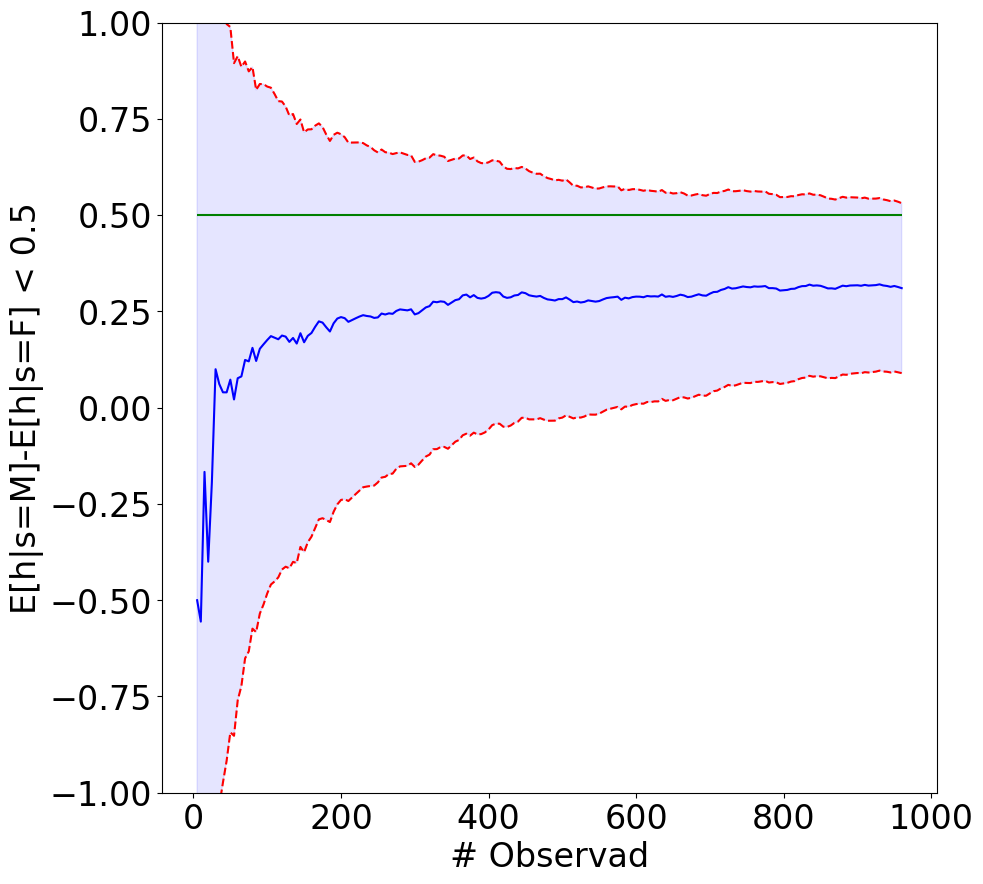

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, ys, color="b")
ax.plot(xs, ys + cs, color="r", linestyle="dashed")
ax.plot(xs, ys-cs, color="r", linestyle="dashed")
ax.fill_between(xs, ys-cs, ys+cs, color="b", alpha=0.1)
ax.hlines(y=threshold, xmin=np.min(xs), xmax=np.max(xs), color="g")
ax.set_ylim((-1, 1))
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_ylabel("E[h|s=M]-E[h|s=F] < 0.5", fontsize=24)
ax.set_xlabel("# Observad", fontsize=24)
#ax.set_xlabel("steps")

In [31]:
fig.savefig("plots/adult-left-initial.png")

In [32]:
xs, values = get_values_for_term(spec_history, my_spec.right_child.left_child.expectation_term)
ys, cs, deltas = zip(*[(value.val, value.epsilon, value.delta) for value in values])
xs, ys, cs, deltas = (np.array(t) for t in [xs, ys, cs, deltas])

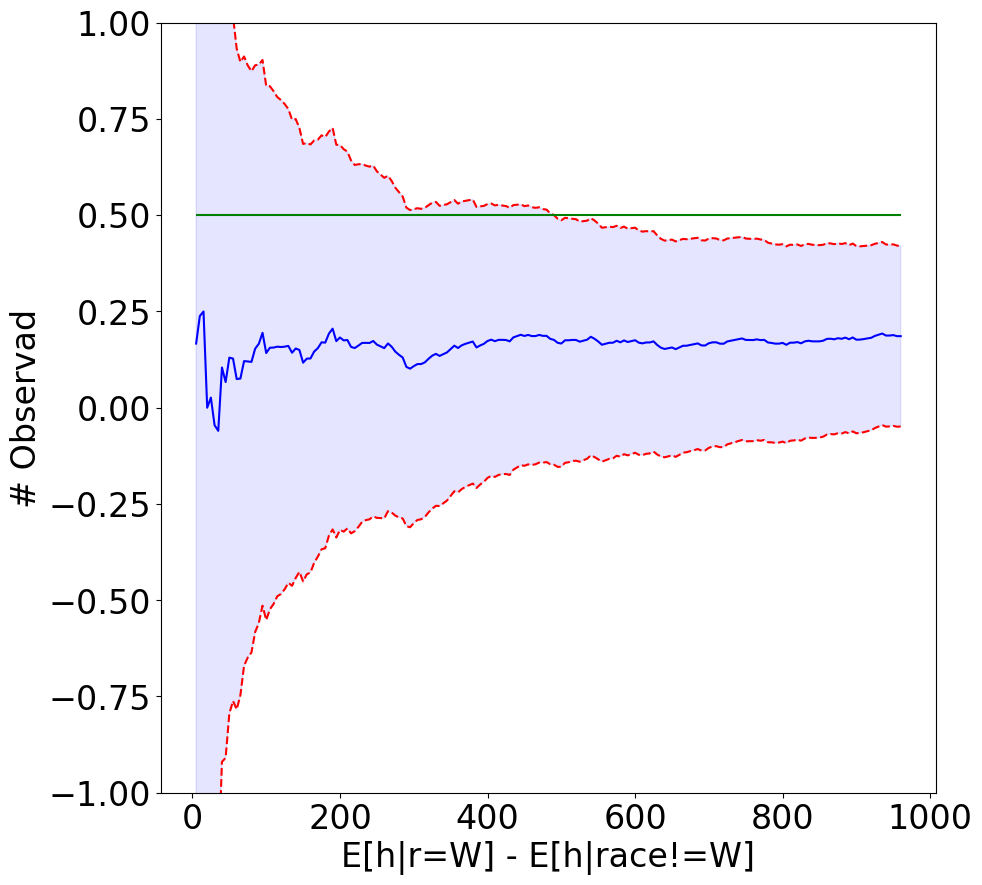

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, ys, color="b")
ax.plot(xs, ys + cs, color="r", linestyle="dashed")
ax.plot(xs, ys-cs, color="r", linestyle="dashed")
ax.fill_between(xs, ys-cs, ys+cs, color="b", alpha=0.1)
ax.hlines(y=threshold, xmin=np.min(xs), xmax=np.max(xs), color="g")
ax.set_ylim((-1, 1))
ax.set_xlabel("E[h|r=W] - E[h|race!=W]", fontsize=24)
ax.set_ylabel("# Observad", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

In [34]:
fig.savefig("plots/adult-right-initial.png")

***
## After refining the threshold

In [35]:
view_name_upd = "federal_employees_upd"

In [36]:
my_spec = get_spec2()
view = database.create_materialized_view(
    view_name_upd,
    query=(lambda data: data[data.workclass == "Federal-gov"]),
    specification=my_spec,
    observation_key="id",
    spec_args={"include_confidence": True, "delta": req_delta, "optimization_frequency": 5, "our_approach": True},
    progress_bar=tqdm
)

960it [00:07, 135.01it/s]


In [37]:
spec_history = database.views[view_name_upd].observer.spec_val_history

In [38]:
xs, values = get_values_for_term(spec_history, my_spec)
ys, deltas = zip(*[(value.val, value.delta) for value in values])

In [39]:
view_name_upd2 = "federal_veri"

In [40]:
my_spec2 = get_spec2()
view = database.create_materialized_view(
    view_name_upd2,
    query=(lambda data: data[data.workclass == "Federal-gov"]),
    specification=my_spec2,
    observation_key="id",
    spec_args={"include_confidence": True, "delta": req_delta, "optimization_frequency": 5, "our_approach": False},
    progress_bar=tqdm
)

960it [00:01, 912.11it/s] 


In [41]:
spec_history2 = database.views[view_name_upd2].observer.spec_val_history

In [42]:
xs2, values2 = get_values_for_term(spec_history2, my_spec2)
ys2, deltas2 = zip(*[(value.val, value.delta) for value in values2])

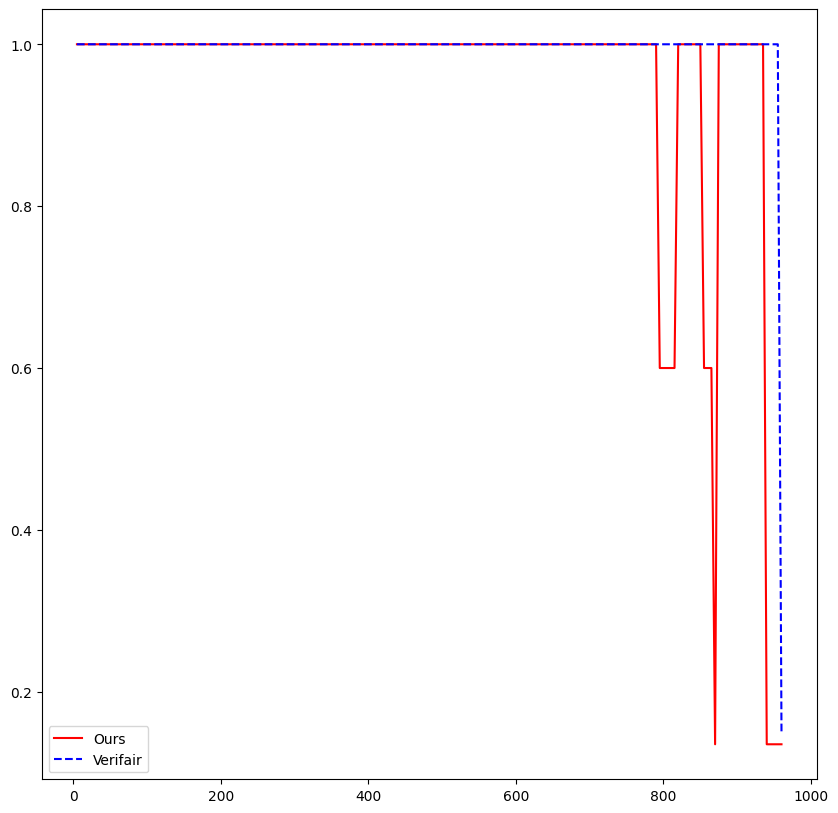

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, deltas, label="Ours", color="r")
ax.plot(xs, deltas2, label="Verifair", color="b", linestyle="dashed")
ax.legend()

In [44]:
database.views[view_name_upd].observer.optimization_achieved_step, database.views[view_name_upd2].observer.optimization_achieved_step

(870, 960)

In [45]:
np.min([x for x, delta in zip(xs, deltas2) if delta <= req_delta])

960

In [46]:
xs_l, values_l = get_values_for_term(spec_history, my_spec.left_child)
xs_r, values_r = get_values_for_term(spec_history, my_spec.right_child)

In [47]:
values_l[-1].delta, values_r[-1].delta

(0.13476892449046365, 0.00036034866019955304)

In [48]:
my_spec.left_child, my_spec.right_child

((E[high_income | sex = Male] - E[high_income | sex = Female] < 0.55),
 (E[high_income | race = White] - E[high_income | race != White] < 0.5))